In [1]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

ModuleNotFoundError: No module named 'tensorflow'

In [7]:
dataset_path = "C:\main project\kvasir-dataset-v2"
image_size = 224, 224
batch_size = 128

train_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)


val_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


In [8]:
class_names = train_ds.class_names

In [9]:
# Returns the cardinality of the data
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape = (224,224, 3))


for layer in base_model.layers:
        layer.trainable=True
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

12683000/12683000 [==============================] - 2s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 8)                 376328    
                                                                 
Total params: 3372680 (12.87 MB)
Trainable params: 3348280 (12.77 MB)
Non-trainable params: 24400 (95.31 KB)
_________________________________________________________________


In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-5)

best = ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [14]:
model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[reduce_lr, best, early_stop])

Epoch 1/50
50/50 [==============================] - 215s 4s/step - loss: 0.8505 - accuracy: 0.7980 - val_loss: 3.4142 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 191s 4s/step - loss: 0.1186 - accuracy: 0.9566 - val_loss: 3.6977 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 187s 4s/step - loss: 0.0310 - accuracy: 0.9884 - val_loss: 3.4912 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 187s 4s/step - loss: 0.0118 - accuracy: 0.9973 - val_loss: 3.4708 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 187s 4s/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 2.2291 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 180s 4s/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 3.0580 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 176s 3s/step - loss: 0.0

In [15]:
model.save("MobileNetV3.h5")

In [16]:
history = model.history

In [17]:
loss = history.history['loss'] + history.history['loss']
val_loss = history.history['val_loss'] + history.history['val_loss']
accuracy = history.history['accuracy'] + history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history.history['val_accuracy']

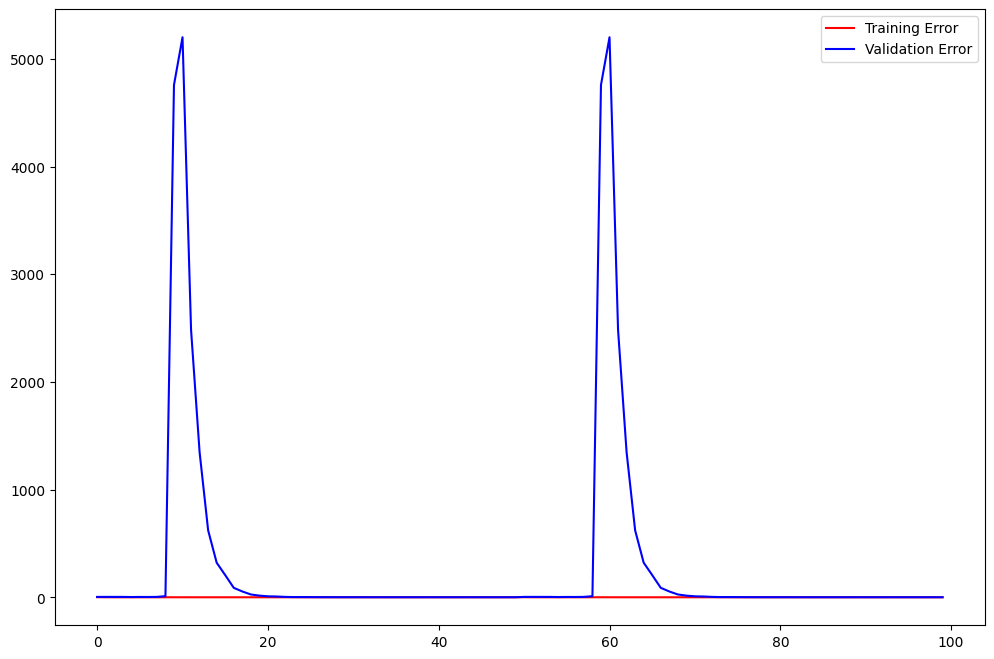

In [18]:
plt.figure(figsize=(12,8))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

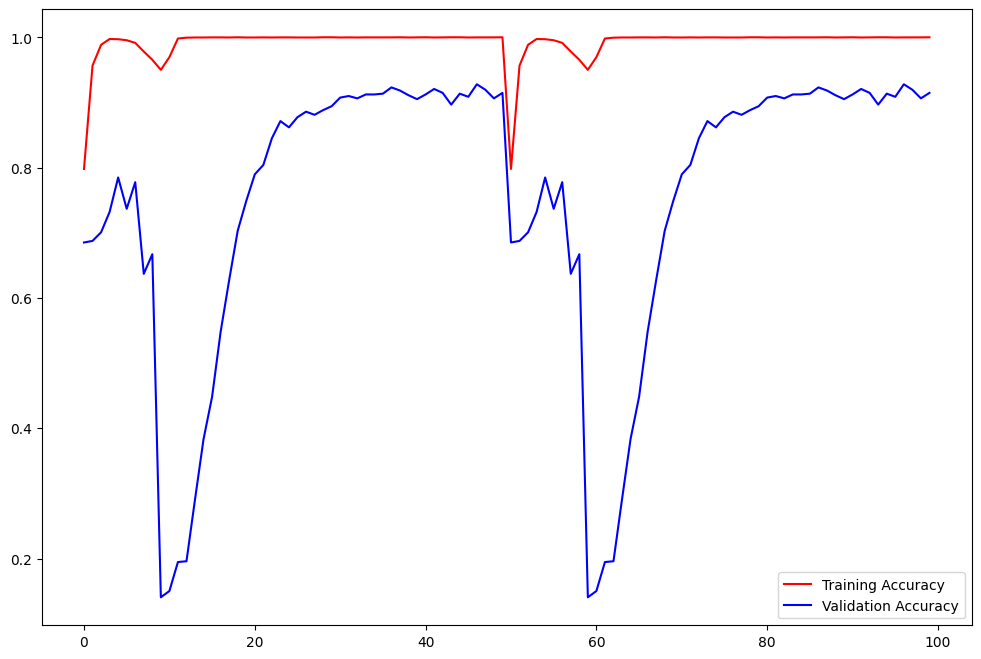

In [19]:
plt.figure(figsize=(12,8))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

In [20]:
true_labels = []
predicted_labels = []

# Iterate through test dataset to get true labels
for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Assuming one-hot encoded labels

    # Predict labels using the model
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert lists to NumPy arrays for easier processing
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

4/4 [==============================] - 1s 129ms/step


In [21]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


Confusion Matrix:
[[ 92   2   0   0   0   0   0   0]
 [ 12  80   0   0   0   0   0   0]
 [  0   0  62   0   0  20   0   0]
 [  0   0   0  93   0   0   4   2]
 [  0   0   0   0 111   0   0   0]
 [  0   0  10   0   1  82   0   0]
 [  0   0   0   2   1   0  95   1]
 [  0   0   1   2   0   0   2  93]]


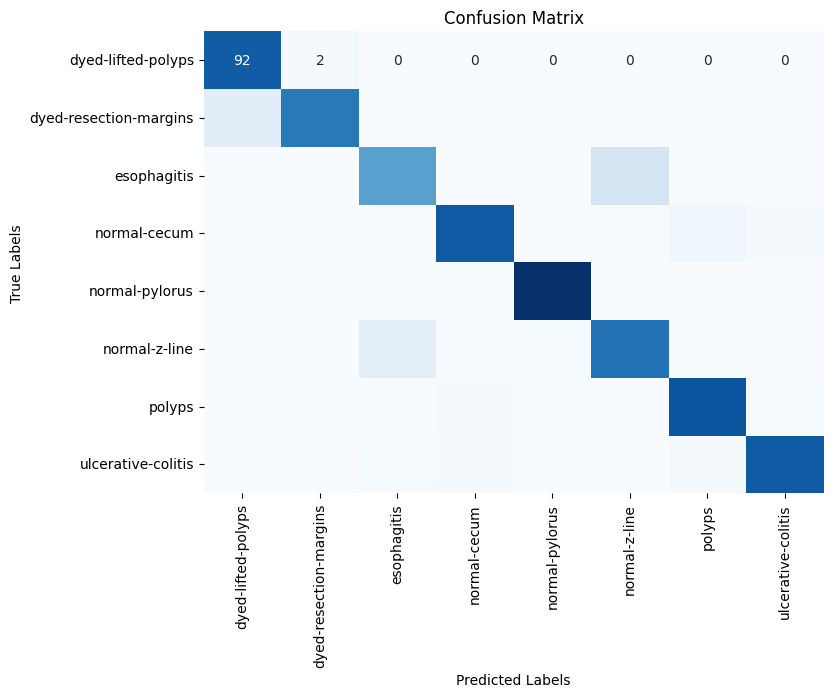

In [22]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()